<a href="https://colab.research.google.com/github/githubforkj/signate_studentcup2022/blob/main/students_cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

# Implementaion

## BERT

### Settings

In [ ]:
# signateとの連携

!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

In [ ]:
# コンペのデータをダウンロード
!signate download --competition-id={735}


In [ ]:
# install 
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
!pip install transformers
!pip install googletrans==4.0.0-rc1

### Preprocessing




In [ ]:
# import library

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization # to create AdamW optimizer
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm

# import pre-trained models
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import AlbertTokenizer, TFAlbertModel


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tf.get_logger().setLevel('ERROR')

In [ ]:
#学習用データと評価用データの読み込み
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [ ]:
#データのサイズ確認
print(train_df.shape)
print(test_df.shape)

(1516, 3)
(1517, 2)


In [ ]:
# 学習データの確認
train_df.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [ ]:
# テストデータの確認
test_df.head()

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...


In [ ]:
#学習用データと評価用データを結合する (両データに対し一括で前処理を行うため)
combined = train_df.append(test_df, ignore_index=True)

In [ ]:
#以下の手順でdescriptionデータのクリーニングを行う.
# <li>などのhtmlタグを削除する
# アルファベット以外の文字をスペースに置き換える
# 単語長が3文字以下のものは削除する
# ステミング（単語の語幹を取り出す作業のこと. 派生語を同じ単語として扱えるようにする）

import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_normalize)
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

combined_cleaned = combined.copy()
combined_cleaned['description'] = cleaning(combined['description'])

In [ ]:
combined_cleaned.head()

,id,description,jobflag
0,0,develop cut edg applic that perform superbl ac...,3.0
1,1,design develop high qualiti scalabl effici sol...,3.0
2,2,function point person network strategi work re...,4.0
3,3,work technic design develop releas deploy clou...,3.0
4,4,quantifi resourc requir task project relat ent...,4.0


In [ ]:
# 学習データをさらに、学習用：検証用に7:3で分割する
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df,train_size=0.7, random_state=0)

#### Creating Pipeline

In [ ]:
# モデル一つずつに対してパイプラインを設計する

#### Add train data with Googletrans
- en-ja-en
- en-it-en
- en-fr-en

In [ ]:
train_df.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [ ]:
from googletrans import Translator

translator = Translator()
response = translator.translate('Hello',dest ='ja')
response.text

'こんにちは'

In [ ]:
response = translator.translate(train_df['description'][0],dest='ja')
response.text

'<li>すべてのプラットフォームで見事に実行される最先端のWebアプリケーションを開発します。</li> <li>数週間から数ヶ月の範囲のプロジェクトについて、職域を超えたチームとの非常に協力的な環境で作業します。Li> <li>製品配信プロセス全体で創造的かつ戦略的に問題解決するため、高品質の高品質を維持してください。</li> <li>技術的および非技術的なピアと非技術的なピアの両方で作業を効果的に伝えることができます</li> <li>新しいWebテクノロジー/テクニックに興奮してください</li> <li>他のシステムやテクノロジーと簡単に統合する堅実なフロントエンドアーキテクチャ</li> <li>他の分野（バックエンド、UX、デザイン、QA）</li> <li>クロスブラウザーとクロスプラットフォームのディスプレイとパフォーマンスを含む、Q/A自身の作業に必要な細部に優れた注意を払っている</li> </ul>'

#### ensemble Bert some models

In [ ]:
# bert
tokenizer1 = BertTokenizer.from_pretrained('bert-base-cased')

# roberta
tokenizer2 = RobertaTokenizer.from_pretrained('roberta-base')
# albert
tokenizer3 = AlbertTokenizer.from_pretrained('albert-base-v2')
model3 = TFAlbertModel.from_pretrained('albert-base-v2')


In [ ]:
token1 = tokenizer1.encode_plus(
    train_df['description'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)
token2 = tokenizer2.encode_plus(
    train_df['description'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)
token3 = tokenizer3.encode_plus(
    train_df['description'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
# トレーニングデータの作成
def generate_training_data(train_df,ids,masks,tokenizer):
    for i, text in tqdm.tqdm(enumerate(train_df['description'])):  #tqdmのままだと回らないので注意
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids,masks

In [ ]:
X_input_ids = np.zeros((len(train_df),256))
X_attn_masks = np.zeros((len(train_df),256))

In [ ]:
X_input_ids.shape

(1516, 256)

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(train_df, X_input_ids, X_attn_masks, tokenizer)

1516it [00:05, 297.65it/s]


In [ ]:
labels = np.zeros((len(train_df),4))
print(labels.shape)

(1516, 4)


In [ ]:
labels[np.arange(len(train_df)),train_df['jobflag'].values - 1] = 1 # python index starts from 0 not 1

In [ ]:
labels  # one-hot

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

In [ ]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

### Learning


In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction)

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [ ]:
dataset = dataset.shuffle(1516).batch(16,drop_remainder=True)

In [ ]:
# spliting train_df into train and validation
p = 0.7
train_size = int((len(train_df)//16)*p)

In [ ]:
train_size

65

In [ ]:
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

↑ここでデータセットを分けて学習したのち、どのように検証データセットで正解を出せばよいのか？？？

In [ ]:
from transformers import TFBertModel

In [ ]:
# import pretrained model
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# fine turning??
input_ids = tf.keras.layers.Input(shape=(256,), name = 'input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(256,), name = 'attention_mask', dtype='int32')

bert_embds = bert_model.bert(input_ids, attention_mask=attention_masks)[1]
intermediate_layer = tf.keras.layers.Dense(256, activation='relu', name = 'intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(4,activation = 'softmax', name = 'output_layer')(intermediate_layer)

model = tf.keras.Model(inputs = [input_ids, attention_masks], outputs = output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         multiple             108310272   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 intermediate_layer (Dense)     (None, 256)          196864      ['bert[1][1]']             

In [ ]:
# turning paramater?

optim = tf.keras.optimizers.Adam(learning_rate = 3e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
# 後に、f1 scoreも記載する

In [ ]:
model.compile(optimizer = optim, loss=loss_func, metrics = [acc])

In [ ]:
# fitting model to student-cup dataset
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
65/65 [==============================] - 73s 983ms/step - loss: 1.0829 - accuracy: 0.5173 - val_loss: 0.7066 - val_accuracy: 0.7284
Epoch 2/3
65/65 [==============================] - 64s 980ms/step - loss: 0.7478 - accuracy: 0.7163 - val_loss: 0.7182 - val_accuracy: 0.6897
Epoch 3/3
65/65 [==============================] - 61s 946ms/step - loss: 0.5359 - accuracy: 0.8038 - val_loss: 0.4293 - val_accuracy: 0.8750


#### Hyper parameters turning with grid search

In [ ]:
# グリッドサーチでハイパーパラメータのチューニング

# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# pipe_svc = SVC(random_state=1)
# param_range = [0.001,0.01,0.1,1,10,100]
# param_grid = [{'C':param_range, 'kernel':['linear']},{'C':param_range, 'gamma':param_range,'kernel':['rbf']}]
# gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='f1',cv=10,n_jobs=-1)
# gs = gs.fit(x_bow_train, y_bow_train)
# print(gs.best_score_)
# print(gs.best_params_)

In [ ]:
# val_dsの形状の中身を確認したい

list(val_ds.as_numpy_iterator())

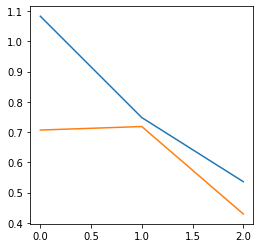

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.show()

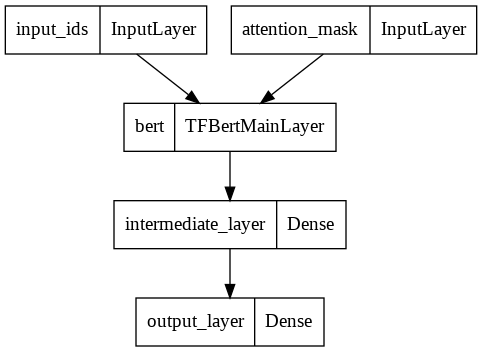

In [ ]:
# モデルの形状を確認する
tf.keras.utils.plot_model(model)

In [ ]:
# モデルの保存(セッション接続中のみ、colabに保存される)
model.save('occupation_model')

### Prediction

In [ ]:
# 保存したモデルを読み込む
loaded_model = tf.keras.models.load_model('occupation_model')

In [ ]:
# カテゴリカル変数(テキスト)→数値
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding = 'max_length',
        add_special_tokens = True,
        return_tensors = 'tf'
    )
    return {
        'input_ids':tf.cast(token.input_ids, tf.float64),
        'attention_mask':tf.cast(token.attention_mask, tf.float64)
    }

In [ ]:
'''
職種カラムのラベリング
"1:Data scientist", "2:Machine learning engineer", "3:Software engineer", "4:Consultant"
'''

def prob2label(input_text_lists):
    classes = [1,2,3,4]
    classes_lists = []
    tokenized_input_text_lists = []
    probs_lists = []
    for input_text in input_text_lists:
        tokenized_input_text_lists.append(prepare_data(input_text, tokenizer))

    for tokenized_input_text in tokenized_input_text_lists:
        probs_lists.append(loaded_model.predict(tokenized_input_text))

    for i in probs_lists:
        output_index = classes[np.argmax(i)]
        classes_lists.append(output_index)
    
    return classes_lists


In [ ]:
# prediction
train_pred = prob2label(train['description'])
val_pred = prob2label(val['description'])

#### Confusion matrix

              precision    recall  f1-score   support

           1      0.786     0.883     0.832       137
           2      0.536     0.682     0.600        22
           3      0.957     0.950     0.953       139
           4      0.978     0.841     0.904       157

    accuracy                          0.879       455
   macro avg      0.814     0.839     0.822       455
weighted avg      0.892     0.879     0.883       455



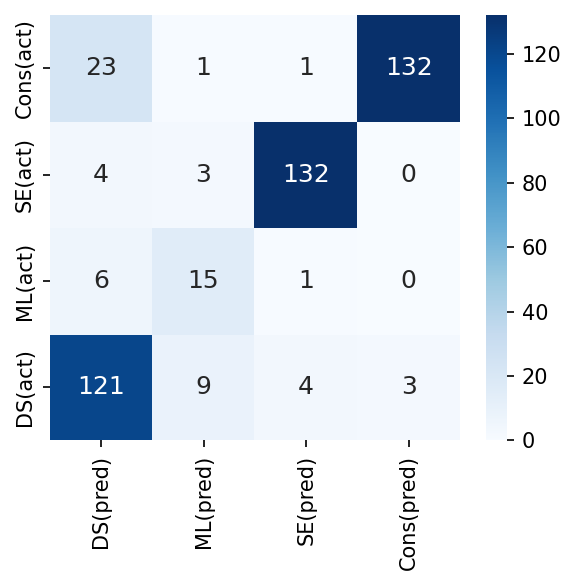

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
re_labels = ["DS", "ML", "SE", "Cons"]

#混同行列の作成
conf_mx = confusion_matrix(val['jobflag'], val_pred, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
 
print(classification_report(val['jobflag'], val_pred, labels=labels, digits=3))

In [ ]:
# predict test dataset
test_pred = prob2label(test_df['description'])

In [ ]:
# 作成した、listをpandasにし、idと結合し、提出用データを作成する
s = pd.Series(test_pred)
submit_data = pd.concat([test_df['id'],s], axis=1)
print(submit_data)

        id  0
0     1516  1
1     1517  4
2     1518  3
3     1519  1
4     1520  3
...    ... ..
1512  3028  3
1513  3029  1
1514  3030  3
1515  3031  1
1516  3032  1

[1517 rows x 2 columns]


In [ ]:
# 提出データをcsvファイルに出力
submit_data.to_csv('./sample.csv', header=None, index=None)

In [ ]:
# 提出
!signate submit --competition-id=735 ./sample.csv --note 二回目のBERT。epochs=3,batchsizeを16で回した。CV=ごちゃついてるため、不明。

You have successfully submitted your predictions.We will send you the submission result to your email address.


# Reference

- https://www.tensorflow.org/text/tutorials/classify_text_with_bert
- https://www.youtube.com/watch?v=wp9BudYGZyA
- [BERTを用いた日本語文書分類タスクの学習・ハイパーパラメータチューニングの実践例
](https://medium.com/karakuri/bert%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E6%97%A5%E6%9C%AC%E8%AA%9E%E6%96%87%E6%9B%B8%E5%88%86%E9%A1%9E%E3%82%BF%E3%82%B9%E3%82%AF%E3%81%AE%E5%AD%A6%E7%BF%92-%E3%83%8F%E3%82%A4%E3%83%91%E3%83%BC%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%AE%E5%AE%9F%E8%B7%B5%E4%BE%8B-2fa5e4299b16)
- ＊＊＊